<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/DS_440_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [11]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#test comment

In [12]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [13]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

fatal: destination path 'Sarcasm_Detection' already exists and is not an empty directory.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train-balanced-sarcasm.csv')   # Make sure path is correct in your google drive
train_bal.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [16]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [17]:
train_bal['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

We can see our dataset is balanced.

In [18]:
train_bal['comment'] = train_bal['comment'].astype('str')
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010826 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [19]:
train_bal[:20]['comment']

0                                            NC and NH.
1     You do know west teams play against west teams...
2     They were underdogs earlier today, but since G...
3     This meme isn't funny none of the "new york ni...
4                       I could use one of those tools.
5     I don't pay attention to her, but as long as s...
6         Trick or treating in general is just weird...
7                       Blade Mastery+Masamune or GTFO!
8     You don't have to, you have a good build, buy ...
9                     I would love to see him at lolla.
10    I think a significant amount would be against ...
11                       Damn I was hoping God was real
12                                 They have an agenda.
13                                          Great idea!
14    Ayy bb wassup, it makes a bit more sense in co...
15                                        what the fuck
16                                               noted.
17    because it's what really bothers him... an

## EDA

In [20]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

In [21]:
# # WordCloud for sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [22]:
# # WordCloud for non-sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [26]:
subreddit_count = sarcastic_com['subreddit'].value_counts()

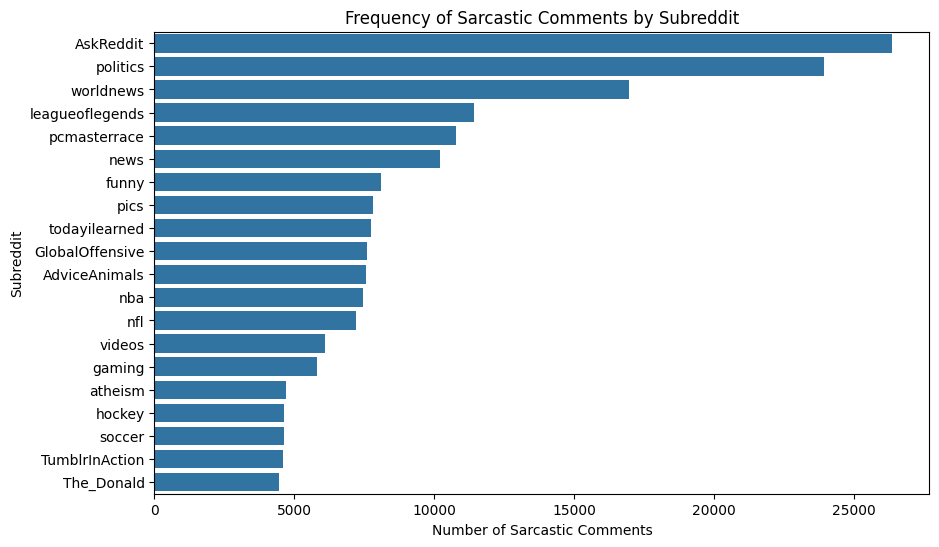

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
top = subreddit_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index)
plt.xlabel('Number of Sarcastic Comments')
plt.ylabel('Subreddit')
plt.title('Frequency of Sarcastic Comments by Subreddit')
plt.show()
